# Final Report: Analysis on MLB Game Inning Score (Group 1)
> 110550004袁孟華 110550079林伯蔚 110550135黃孚翔 110550163張育安 0816135張弘沛

**Hypothesis #1:**
The home team has a chance to come from behind and win when trailing in each inning from the 1st to the 8th. 

**Hypothesis #2:**
The home team has a chance to come from behind and win when trailing by **1 run** in each of the 1st to 8th innings.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

data = pd.read_csv('inningScore.csv') 
print(data.head())

print(data.columns)

  Team  1  2  3  4  5  6  7  8  9  ...  10  11  12  13  14  15  16  17  18  19
0  STL  0  0  0  0  0  0  0  0  1  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
1  PIT  0  2  0  0  0  1  0  1  -  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2  TOR  2  0  0  1  0  0  0  2  0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
3   TB  0  0  1  0  0  0  0  0  2  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
4  NYM  0  0  0  0  0  0  0  3  0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

[5 rows x 24 columns]
Index(['Team', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'R', 'H', 'E',
       'Game', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'],
      dtype='object')


In [70]:
def sum_to_n_inning(To_which_inning: int, plot: bool=True):  
    """
    Calculate the (cumulative) run differences at the specified inning, and plot it.
    ## Parameters
        `To_which_inning: int`: the specified inning

        `plot: bool=True`: whether to plot the calculated result

    ## Return
        None
    """
    # sum from 1st inning to 5th inning for every row
    col_list = [str(i) for i in range(1, To_which_inning+1)]

    # Convert columns to numeric type
    data[col_list] = data[col_list].apply(pd.to_numeric, errors='coerce')   

    data['InningSum'] = data[col_list].sum(axis=1, numeric_only=True)
    sum_data = data[['Team', 'Game', 'InningSum']].copy()

    # For every Game, calculate the abs difference between the two teams 
    # One Game print out one row
    # x.diff(): home - away (lower row minus upper row)
    sum_data.loc[:, 'SumDiff'] = sum_data.groupby('Game')['InningSum'].transform(lambda x: x.diff())

    # only print distinct Game
    diff_data = sum_data[['Game', 'SumDiff']]
    diff_data = diff_data.dropna()
    diff_data['Inning'] = To_which_inning

    if plot:
        plt.xlabel('Difference of scores')
        plt.title(f'Difference of scores at the end of Inning {To_which_inning}')
        sns.histplot(diff_data['SumDiff'], bins=20, kde=True)

    return diff_data


def neg_sum_to_n_inning(To_which_inning: int, diff_inning: float=1, neg_all: bool=True) -> pd.Series:  
    """
    Calculate the (cumulative) run differences at the specified inning, and only return
    those with negative run differences.

    ## Parameters
        `To_which_inning`: the specified inning

        `diff_inning`: Specify the particular difference of score we interested in.

        `neg_all`: If `neg_all=True`, all games that Home is trailing are considered.
                    
    ## Return
        A `pd.Series` of negative (cumulative) run differences.
    """
    # sum from 1st inning to 5th inning for every row
    col_list = [str(i) for i in range(1, To_which_inning+1)]

    # Convert columns to numeric type
    data[col_list] = data[col_list].apply(pd.to_numeric, errors='coerce')   

    data['InningSum'] = data[col_list].sum(axis=1, numeric_only=True)
    sum_data = data[['Team', 'Game', 'InningSum']].copy()

    # For every Game, calculate the abs difference between the two teams 
    # One Game print out one row
    # x.diff(): home - away (lower row minus upper row)
    sum_data.loc[:, 'SumDiff'] = sum_data.groupby('Game')['InningSum'].transform(lambda x: x.diff())

    # only print distinct Game
    diff_data = sum_data[['Game', 'SumDiff']]
    diff_data = diff_data.dropna()
    if neg_all:
        neg_diff_data = diff_data[diff_data['SumDiff'] <= 0]
    else:
        neg_diff_data = diff_data[diff_data['SumDiff'] == -diff_inning]

    return neg_diff_data

## Plot the run difference to the end of inning 1-8

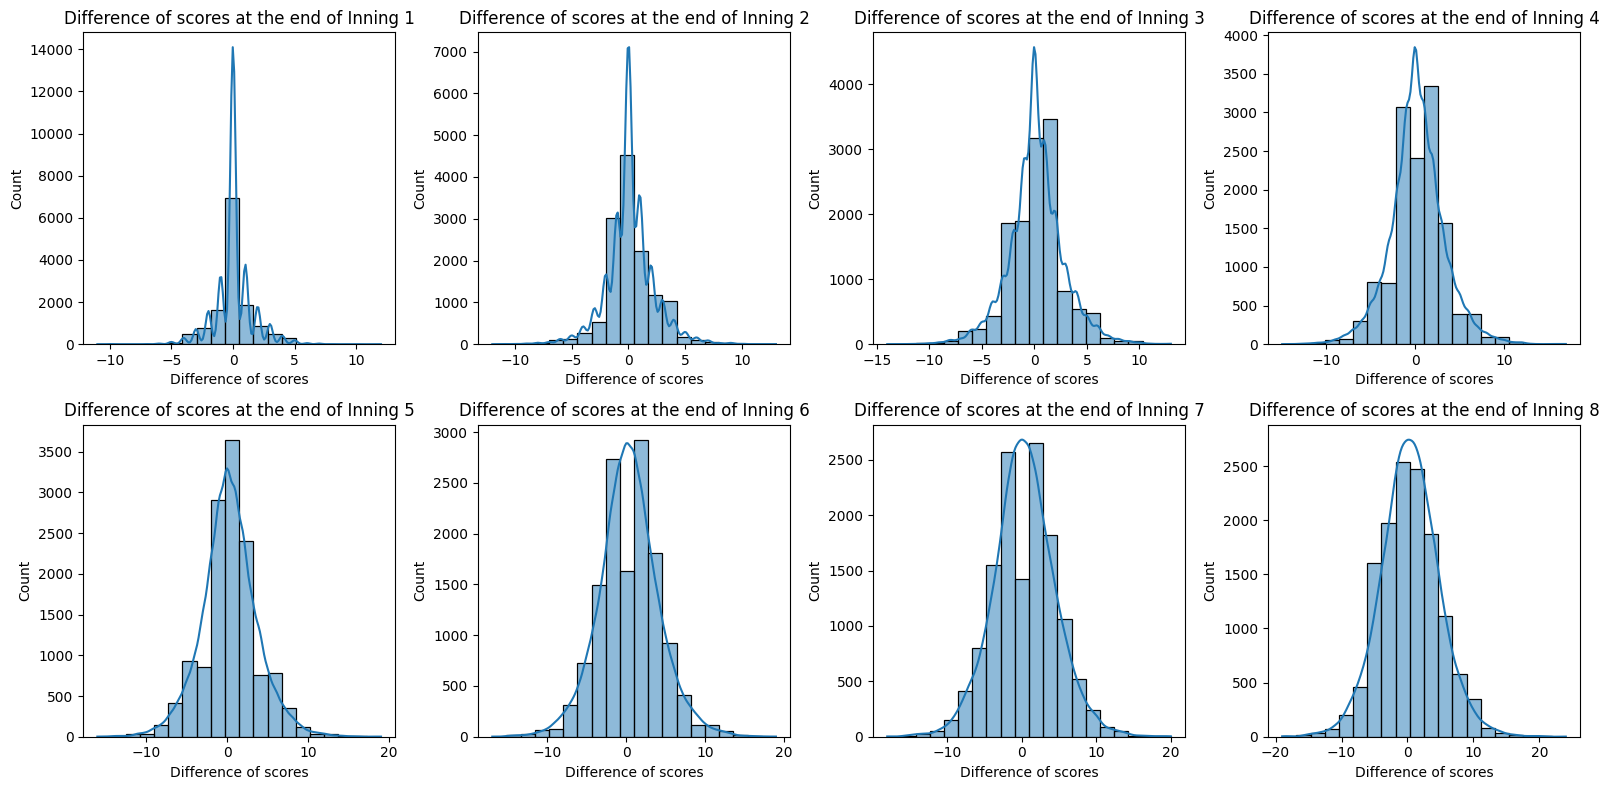

In [71]:
"""
This block in commented for overall efficiency.
"""
# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns

sum_diff_data = []
for i, ax in enumerate(axs.flat, start=1):
    plt.subplot(2, 4, i)  # Set current subplot
    diff_data = sum_to_n_inning(i)
    sum_diff_data.append(diff_data)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Plot Heat map

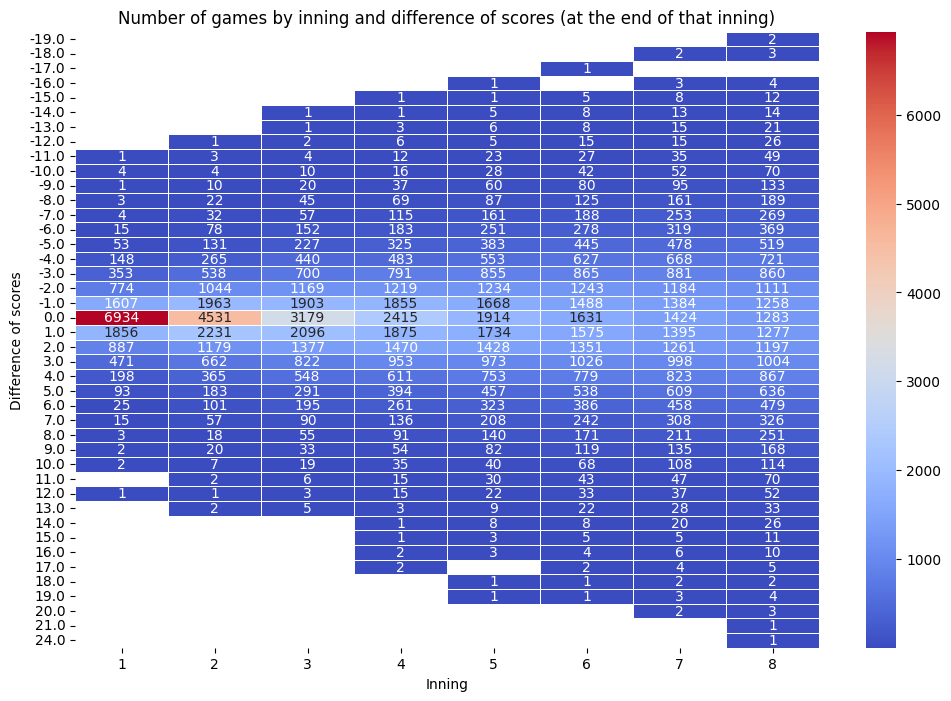

In [72]:
# Concatenate the dataframes in sum_diff_data
concatenated_data = pd.concat(sum_diff_data)

# Count the number of occurrences of each (Inning, SumDiff) pair
count_data = concatenated_data.groupby(['Inning', 'SumDiff']).size().reset_index(name='Count')

# Pivot the DataFrame to have 'Count' as values, 'Inning' as rows, and 'SumDiff' as columns
pivot_data = count_data.pivot(index='SumDiff', columns='Inning', values='Count')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, cmap='coolwarm', annot=True, fmt=".0f", linewidths=.5)
plt.title('Number of games by inning and difference of scores (at the end of that inning)')
plt.xlabel('Inning')
plt.ylabel('Difference of scores')
plt.show()

## Get the run difference to the end of inning 1-8 (only games with negative difference)

In [73]:
def get_neg_diff_data_list(hypothesis: int=1) -> list[pd.Series]:
    """
    Get a list of games indexed by innings according to hypothesis 1 or 2.

    Please refer to beginning of this python notebook for information regarding hypothesis 1 and 2.

    ## Parameter
        `hypothesis: int=1`: specify which hypothesis we are interested in, 
        and the returning list would correspond to that hypothesis.

    ## Return
        A list of `pd.Series` indexed by innings according to hypothesis 1 or 2.
        
        Note that index `i` corresponds to the `i+1`-th inning.

    """
    neg_diff_data_list = []
    for i in range(1, 9):
        if hypothesis == 1:
            neg_diff_data = neg_sum_to_n_inning(i)
        else:
            neg_diff_data = neg_sum_to_n_inning(i, diff_inning=1, neg_all=False)

        neg_diff_mean = neg_diff_data['SumDiff'].mean()
        print(f'(negative) mean diff. at {i}-th inning: {neg_diff_mean}')
        neg_diff_data_list.append(neg_diff_data)

    return neg_diff_data_list


neg_diff_data_list = get_neg_diff_data_list(hypothesis=1)
# neg_diff_data_list = get_neg_diff_data_list(hypothesis=2)
neg_diff_data_list[0]

(negative) mean diff. at 1-th inning: -0.5327877134485197
(negative) mean diff. at 2-th inning: -0.9769195082347483
(negative) mean diff. at 3-th inning: -1.4262958280657396
(negative) mean diff. at 4-th inning: -1.7850219094409774
(negative) mean diff. at 5-th inning: -2.138078783690394
(negative) mean diff. at 6-th inning: -2.4323063877897115
(negative) mean diff. at 7-th inning: -2.711158798283262
(negative) mean diff. at 8-th inning: -2.9945031100824533


,Game,SumDiff
1,360403123,0.0
3,360403130,-2.0
9,360404101,0.0
11,360404113,-1.0
13,360404115,0.0
...,...,...
26851,401361970,-2.0
26857,401361976,-2.0
26861,401361978,0.0
26863,401361979,-1.0


## Run difference at the End of the Game

(13450, 2)
ScoreDiff
 1.0     2200
-1.0     1489
 2.0     1245
-2.0     1152
 3.0      992
-3.0      949
 4.0      806
-4.0      762
-5.0      578
 5.0      574
 6.0      410
-6.0      406
 7.0      315
-7.0      306
 8.0      217
-8.0      193
 9.0      148
-9.0      142
 10.0      98
-10.0      95
-11.0      63
 11.0      60
 12.0      41
-12.0      35
 13.0      33
-13.0      32
 14.0      23
-14.0      17
-15.0      14
 15.0      10
 0.0        8
 16.0       8
-16.0       5
 18.0       4
 17.0       4
-18.0       3
-17.0       3
-19.0       2
 19.0       2
 21.0       2
 20.0       2
-20.0       1
-21.0       1
Name: count, dtype: int64


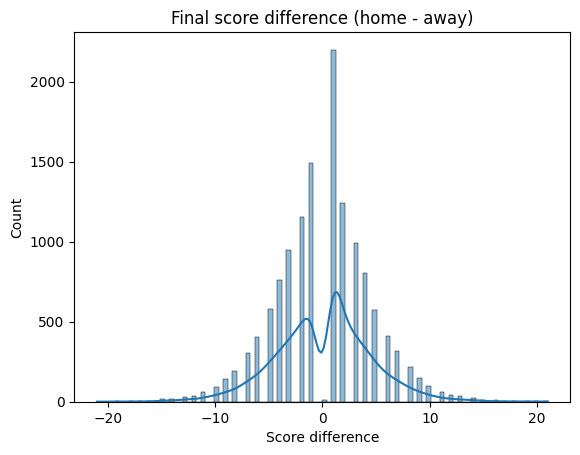

In [74]:
# sum elements in all_inning if it is not NaN
all_inning = [str(i) for i in range(1, 20)]
# print(all_inning)

data[all_inning] = data[all_inning].replace({np.nan: 0, '-': 0})

# Convert columns to numeric type
data[all_inning] = data[all_inning].apply(pd.to_numeric, errors='coerce')

data["final_score"] = data[all_inning].sum(axis=1, numeric_only=True)

# calculate the difference between the two teams per game
data['ScoreDiff'] = data.groupby('Game')['final_score'].transform(lambda x: x.diff())

# print(data.head())

"""Final score difference"""
ScoreDiff_data = data[['Game', 'ScoreDiff']].dropna()

print(ScoreDiff_data.shape)
print(ScoreDiff_data['ScoreDiff'].value_counts())

plt.xlabel('Score difference')
plt.ylabel('Count')
plt.title('Final score difference (home - away)')
sns.histplot(ScoreDiff_data['ScoreDiff'], bins=100, kde=True)

plt.show()

## Divide final run differences with the $k$-th inning results (inning 1 ~ 8)

score diff mean:  -0.5575739226965385
sample size: 9909
score diff mean:  -1.055812876331635
sample size: 8636
score diff mean:  -1.5129337539432177
sample size: 7925
score diff mean:  -1.9738899933730947
sample size: 7545
score diff mean:  -2.322620689655172
sample size: 7250
score diff mean:  -2.6360817477096545
sample size: 7095
score diff mean:  -2.891108891108891
sample size: 7007
score diff mean:  -3.112730946882217
sample size: 6928


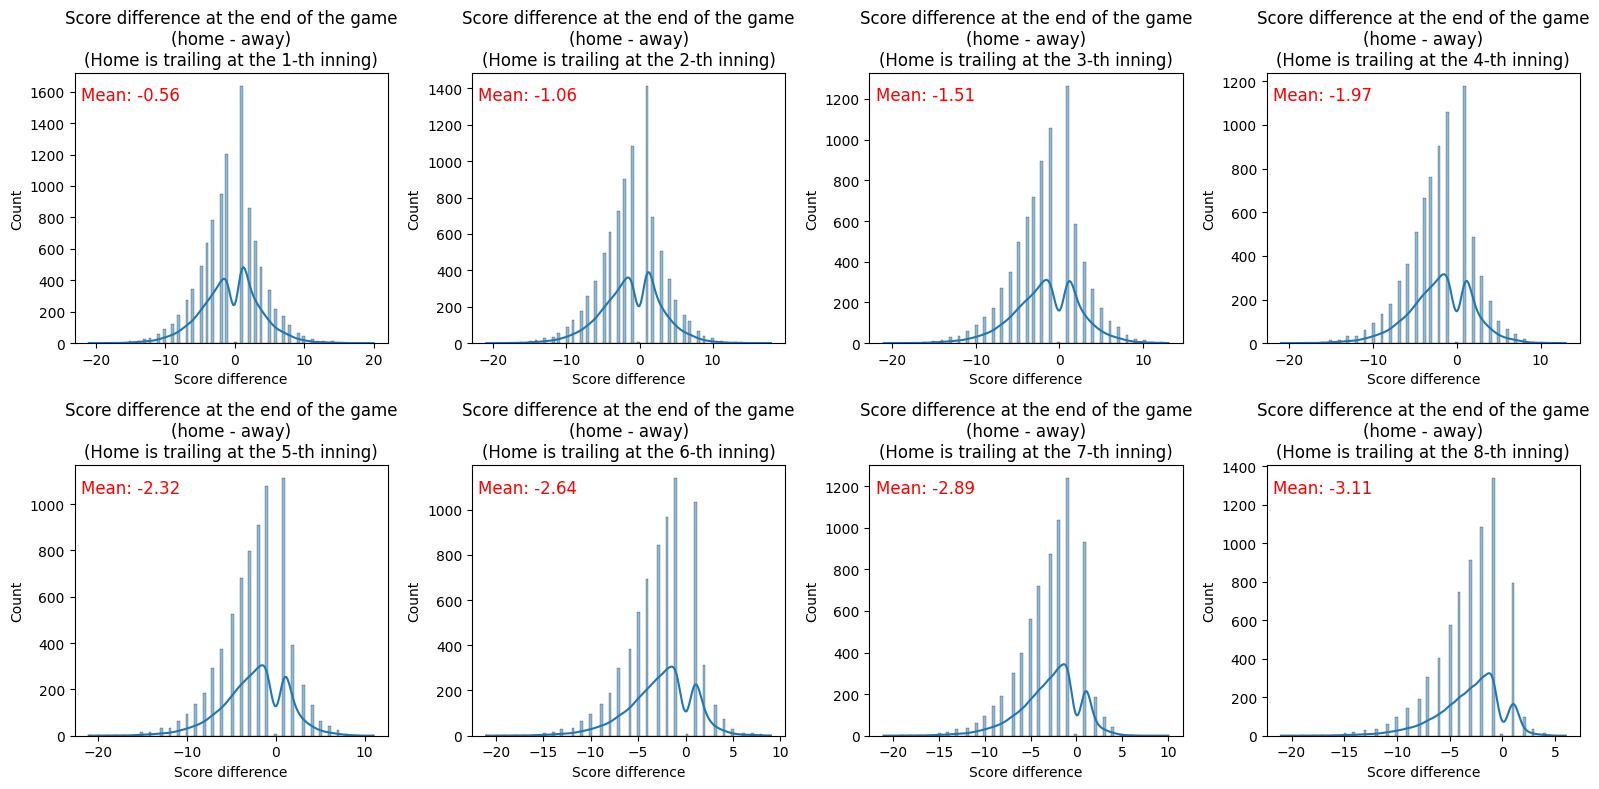

In [75]:
"""
`score_diff_data_set` is a set of final score differences (home - away)
`score_diff_data_set[i]` corresponds to the `i+1`-th inning
"""
score_diff_data_set = []
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns

for i in range(8):
    plt.subplot(2, 4, i + 1)  # Set current subplot
    score_diff_data_set.append(ScoreDiff_data[ScoreDiff_data['Game'].isin(neg_diff_data_list[i]['Game'])])
    score_diff_mean = score_diff_data_set[i]['ScoreDiff'].mean()
    # print(score_diff_data_set[i])
    print('score diff mean: ', score_diff_mean)
    print('sample size:', score_diff_data_set[i].shape[0])


    plt.text(0.02, 0.95, f'Mean: {score_diff_mean:.2f}', transform=plt.gca().transAxes, color='red', fontsize=12, verticalalignment='top')
    plt.xlabel('Score difference')
    plt.ylabel('Count')
    plt.title(f'Score difference at the end of the game\n(home - away)\n(Home is trailing at the {i+1}-th inning)')
    sns.histplot(score_diff_data_set[i]['ScoreDiff'], bins=100, kde=True)

plt.tight_layout()
plt.show()

## Calculate & plot confidence intervals (t-test)

In [76]:
from scipy import stats

confidence = 0.95
confidence_intervals = []
for i in range(8):
    lower, upper = stats.t.interval(
        confidence=confidence,
        df=score_diff_data_set[i].shape[0] - 1,
        loc=score_diff_data_set[i]['ScoreDiff'].mean(),
        scale=stats.sem(score_diff_data_set[i]['ScoreDiff'])
    )
    confidence_intervals.append((lower, upper))
    print(f'CI of final run difference (for {i + 1}-th inning): ({lower:.3f}, {upper:.3f})')

CI of final run difference (for 1-th inning): (-0.643, -0.472)
CI of final run difference (for 2-th inning): (-1.145, -0.967)
CI of final run difference (for 3-th inning): (-1.602, -1.424)
CI of final run difference (for 4-th inning): (-2.061, -1.887)
CI of final run difference (for 5-th inning): (-2.407, -2.238)
CI of final run difference (for 6-th inning): (-2.717, -2.555)
CI of final run difference (for 7-th inning): (-2.968, -2.814)
CI of final run difference (for 8-th inning): (-3.186, -3.039)


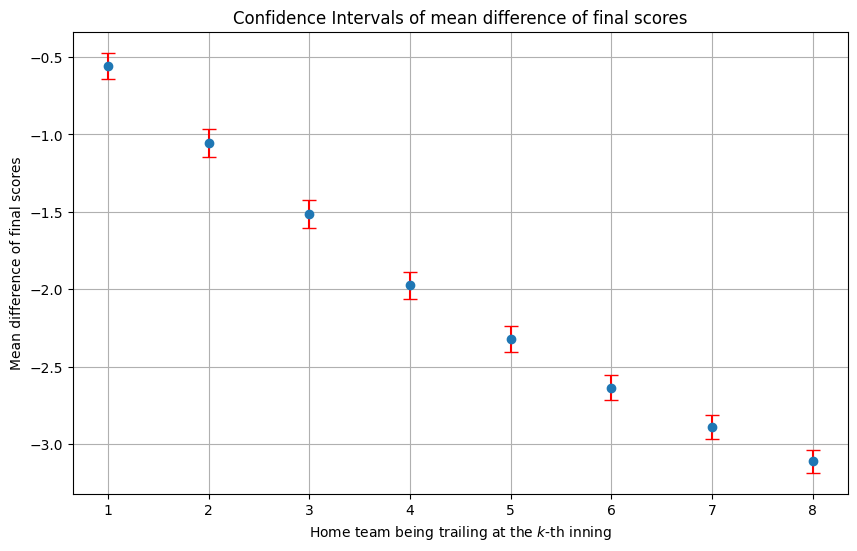

In [77]:
# X positions for the confidence intervals
x_positions = range(1, len(confidence_intervals) + 1)

# Extract lower and upper bounds
lower_bounds = [interval[0] for interval in confidence_intervals]
upper_bounds = [interval[1] for interval in confidence_intervals]

# Calculate the means (for plotting purposes)
means = [(low + high) / 2 for low, high in confidence_intervals]

# Plotting
plt.figure(figsize=(10, 6))
# plt.errorbar(x_positions, means, yerr=[(mean - low, high - mean) for mean, low, high in zip(means, lower_bounds, upper_bounds)], 
            #  fmt='o', ecolor='red', capsize=5, linestyle='None')

plt.errorbar(x_positions, means, yerr=[mean - low for mean, low, high in zip(means, lower_bounds, upper_bounds)], 
             fmt='o', ecolor='red', capsize=5, linestyle='None')

plt.xticks(x_positions)
plt.xlabel('Home team being trailing at the $k$-th inning')
plt.ylabel('Mean difference of final scores')
plt.title('Confidence Intervals of mean difference of final scores')
plt.grid(True)
plt.show()


## Goodness-of-fit (for the distribution of final score differences)

There are five goodness-of-fit tests against differnet distributions:
1. Normal
2. Poisson
3. Exponential
4. Bimodal
5. Folded normal

In [78]:
'''
Preform normality test on ScoreDiff
'''
from scipy import stats

ScoreDiff_data = ScoreDiff_data['ScoreDiff']
stat, p_val = stats.kstest(ScoreDiff_data, 'norm', [ScoreDiff_data.mean(), ScoreDiff_data.std()])
print(f'mean: {ScoreDiff_data.mean()}; variance: {ScoreDiff_data.var()}')
if p_val > 0.05:
    print('normally distributed')
else:
    print('not normally distributed')

mean: 0.12973977695167285; variance: 20.438739243751904
not normally distributed


In [79]:
'''
Try test for Poisson or Exponential (with abs(x.diff())).
Since the mean and variance of our data is not close, it is unlikely a Poisson distribution.
Same reason for the exponential distribution.
'''

abs_data = abs(ScoreDiff_data)
# The mean and the variance are not close.
# That is, the underlying distribution is unlikely Poisson
print(f'mean: {abs_data.mean()}; variance: {abs_data.var()}')
stat, p_val = stats.kstest(abs_data, stats.poisson.cdf, [abs_data.mean()])
if p_val > 0.05:
    print('poisson distribution')
else:
    print('not poisson distribution')


scale = 1 / abs_data.mean()
stat, p_val = stats.kstest(abs_data, stats.expon.cdf, [0, scale])
if p_val > 0.05:
    print('exponentially distributed')
else:
    print('not exponentially distributed')

mean: 3.5749442379182157; variance: 7.674396327472558
not poisson distribution
not exponentially distributed


estimated param: (0.00011400679955283176, 0, 4.522615649759954)


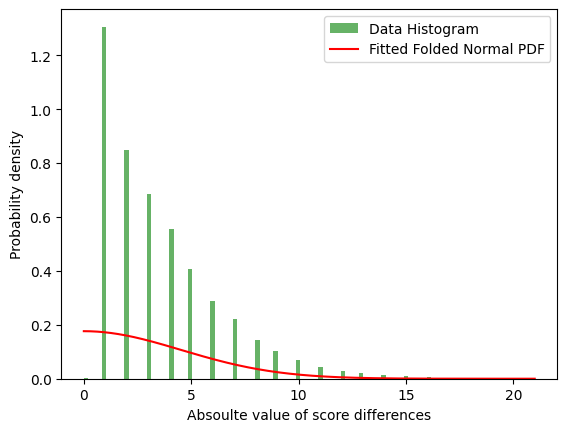

Kolmogorov-Smirnov Test: D=0.17439918601076682, p-value=0.0
Reject the null hypothesis: The data does not follow the folded normal distribution.


In [80]:
"""
Test whether our data fits "folded normal distribution".
"""

# Plot histogram of the data
plt.hist(abs_data, bins=100, density=True, alpha=0.6, color='g', label='Data Histogram')

# Fit the data to a folded normal distribution
param = stats.foldnorm.fit(abs_data, floc=0)

print(f'estimated param: {param}')

# Get the PDF of the fitted folded normal distribution
x = np.linspace(0, max(abs_data), 1000)
pdf_fitted = stats.foldnorm.pdf(x, *param)
plt.plot(x, pdf_fitted, 'r-', label='Fitted Folded Normal PDF')

plt.xlabel('Absoulte value of score differences')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Kolmogorov-Smirnov Test
D, p_value_ks = stats.kstest(abs_data, 'foldnorm', args=param)
print(f'Kolmogorov-Smirnov Test: D={D}, p-value={p_value_ks}')

# Interpretation
alpha = 0.05  # Common significance level
if p_value_ks > alpha:
    print("Fail to reject the null hypothesis: The data follows the folded normal distribution.")
else:
    print("Reject the null hypothesis: The data does not follow the folded normal distribution.")

In [81]:
"""
Try bimodal distribution
"""
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

ScoreDiff_data = ScoreDiff_data.values
ScoreDiff_data = ScoreDiff_data.reshape(-1, 1)

print(ScoreDiff_data)

# 判斷雙峰模型是否比單峰模型更好
gmm1 = GaussianMixture(n_components=1)
gmm1.fit(ScoreDiff_data)

gmm2 = GaussianMixture(n_components=2)
gmm2.fit(ScoreDiff_data)

print("Single component AIC:", gmm1.aic(ScoreDiff_data))
print("Two component AIC:", gmm2.aic(ScoreDiff_data))

# 從上面可得知 資料不適合 Gaussion distribution，而 bimodal 又比 Gaussion 來的差(AIC 值更大)，所以不太合適


param_grid = {
    'n_components': [2],  # 固定為雙峰模型
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # 探索不同的協方差類型
    'n_init': [1, 5, 10],  # 探索不同的初始化次數
    'random_state': [42]  # 設置隨機種子以保證結果可重現
}

# 創建GaussianMixture模型
gmm = GaussianMixture()

# 使用GridSearchCV進行參數搜索
search = GridSearchCV(gmm, param_grid, cv=5)  # 5-fold cross-validation
search.fit(ScoreDiff_data)

# 最佳參數
best_params = search.best_params_
print("Best parameters found: ", best_params)

# 使用最佳參數進行最終擬合
best_gmm = GaussianMixture(**best_params)
best_gmm.fit(ScoreDiff_data)

# 顯示最終模型的均值和協方差
print("Means: ", best_gmm.means_)
print("Covariances: ", best_gmm.covariances_)

# 計算標準差
standard_deviations = np.sqrt(best_gmm.covariances_ if best_params['covariance_type'] != 'tied' else np.array([best_gmm.covariances_]))
print("Standard deviations: ", standard_deviations)

[[ 3.]
 [-2.]
 [ 1.]
 ...
 [ 1.]
 [-4.]
 [-7.]]
Single component AIC: 78756.90801698714
Two component AIC: 78854.22298459051
Best parameters found:  {'covariance_type': 'tied', 'n_components': 2, 'n_init': 5, 'random_state': 42}
Means:  [[-1.46070408]
 [ 2.75275251]]
Covariances:  [[16.26546614]]
Standard deviations:  [[[4.03304676]]]
